**Autor:** [Lucas Lima](https://github.com/lucasouzamil)

# **Análise do Conjunto de Dados de Avaliação de Detecção de Intrusões (CIC-IDS2017)**

Este documento tem como propósito apresentar um resumo da [análise conduzida por Noushin Pervez](https://github.com/noushinpervez/Intrusion-Detection-CICIDS2017), na qual a autora explora e compara diferentes modelos de Machine Learning aplicados à detecção de intrusões, utilizando o [Conjunto de Dados CIC-IDS2017](https://www.unb.ca/cic/datasets/ids-2017.html), desenvolvido pelo Canadian Institute for Cybersecurity.

A proposta deste resumo é implementar, de forma objetiva e simplificada, os dois modelos considerados mais eficazes pela autora em sua análise, tanto para classificação binária quanto para classificação multiclasses, a fim de reproduzir os resultados em um código mais enxuto e direto. Para informações adicionais ou aprofundamento teórico, recomenda-se a consulta ao estudo original.

Este material serve como base para o desenvolvimento de um sistema automatizado capaz de identificar e classificar ameaças cibernéticas em servidores web, com base em dados reais de tráfego de rede.

Trata-se de uma iniciativa com fins exclusivamente educacionais.

## 1. Coleta dos dados

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [130]:
data1 = pd.read_csv('./data/Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv('./data/Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv('./data/Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv('./data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv('./data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
data6 = pd.read_csv('./data/Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv('./data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv('./data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [131]:
# Junção dos diferentes Datasets
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]
data = pd.concat(data_list)

In [132]:
# Removendo datasets para poupar memória
for d in data_list: del d

In [133]:
# Renomeando as colunas para tirar espaços em branco
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [134]:
data.describe().transpose()

c:\Users\Lucas\Desktop\techhack\AF\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Lucas\Desktop\techhack\AF\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.0,53.0,80.0,443.0,65535.0
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-13.0,155.0,31316.0,3204828.5,119999998.0
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.0,2.0,2.0,5.0,219759.0
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.0,1.0,2.0,4.0,291922.0
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.0,12.0,62.0,187.0,12900000.0
...,...,...,...,...,...,...,...,...
Active Min,2830743.0,5.829582e+04,5.770923e+05,0.0,0.0,0.0,0.0,110000000.0
Idle Mean,2830743.0,8.316037e+06,2.363008e+07,0.0,0.0,0.0,0.0,120000000.0
Idle Std,2830743.0,5.038439e+05,4.602984e+06,0.0,0.0,0.0,0.0,76900000.0
Idle Max,2830743.0,8.695752e+06,2.436689e+07,0.0,0.0,0.0,0.0,120000000.0


## 2. Pré-processamento de Dados

In [135]:
# Removendo linhas duplicadas (linhas iguais, todas features iguais)
data.drop_duplicates(inplace = True)

In [136]:
# Substituindo valores infinitos por NaN
data.replace([np.inf, -np.inf], np.nan, inplace = True)

In [137]:
# Corrigir colunas duplicadas (indices iguais)
data = data.loc[:, ~data.columns.duplicated()]

# Corrigir índice duplicado (transforma o índice em uma contagem sequencial (0, 1, 2, ...))
data = data.reset_index(drop=True)

In [138]:
# Identificando valores faltantes NaN
missing = data.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64


In [139]:
# Substituindo valores faltantes NaN pela mediana ()
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

data['Flow Bytes/s'] = data['Flow Bytes/s'].fillna(med_flow_bytes)
data['Flow Packets/s'] = data['Flow Packets/s'].fillna(med_flow_packets)

In [ ]:
# Dropando colunas que não alteram o valor
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

print('Colunas Dropadas:')
dropped_cols

Colunas Dropadas:


Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

In [141]:
# Criando um dicionario que mapeia cada label para seu tipo de ataque
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Criando uma nova coluna no DataBase usando o dicionario attack_map
data['Attack Type'] = data['Label'].map(attack_map)

In [142]:
#Dropando coluna antiga
data.drop('Label', axis = 1, inplace = True)

In [144]:
# Colunas na versão final do pré processamento
feature_order = [col for col in list(data.columns) if col != "Attack Type"]
data_prepro = data

import json
#salvando dados formatados
data_prepro.to_csv("data/data_prepro.csv", index=False)
json.dump(list(feature_order), open("modelos/feature_order.json", "w"))

### Inicio da Pipeline

In [ ]:
data = pd.read_csv("./data/data_prepro.csv")

In [4]:
# Padronizando o dataset
from sklearn.preprocessing import StandardScaler

features = data.drop('Attack Type', axis = 1)
attacks = data['Attack Type']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [5]:
from sklearn.decomposition import IncrementalPCA

size = len(features.columns) // 2
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
  ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

information retained: 99.30%


In [6]:
transformed_features = ipca.transform(scaled_features)
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Attack Type'] = attacks.values

In [7]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,Attack Type
0,-2.357605,-0.054980,0.577367,0.734454,3.730371,0.234648,-0.015694,-0.215593,-0.278501,1.087262,0.032711,0.067621,1.638439,0.371324,-0.794797,0.003730,0.069457,0.614933,-0.658005,-0.596658,-0.350690,-0.714309,-1.721585,-0.069528,-0.420207,0.904754,-0.147988,-0.334371,1.487918,-0.163631,-0.219312,-0.004576,0.002609,0.034128,-0.015853,BENIGN
1,-2.883854,-0.069938,0.911321,1.763147,8.846136,0.620454,-0.056858,1.106466,1.906559,-2.756474,-0.950592,-0.843113,6.052572,1.568504,-4.731659,-0.120694,1.313557,1.949344,-0.497494,-0.591938,-0.199933,-0.566894,-5.606576,0.296477,1.603394,0.594120,0.282642,-2.347082,2.238826,-0.640825,-0.367420,0.010520,0.000645,0.125795,-0.190767,BENIGN
2,-2.416928,-0.056683,0.615335,0.850869,4.304213,0.275779,-0.020438,-0.070542,-0.035290,0.664153,-0.076172,-0.033045,2.132309,0.504258,-1.230418,-0.009935,0.206592,0.763981,-0.642472,-0.598090,-0.334834,-0.697290,-2.155998,-0.032073,-0.196749,0.868293,-0.101730,-0.545536,1.572158,-0.213910,-0.234609,-0.003047,0.002402,0.043993,-0.035273,BENIGN
3,-2.884705,-0.069978,0.912183,1.765263,8.851561,0.618717,-0.057028,1.104621,1.906986,-2.752501,-0.950219,-0.842586,6.055982,1.568418,-4.729850,-0.120534,1.312459,1.950124,-0.499796,-0.593895,-0.200827,-0.566254,-5.609324,0.293264,1.602008,0.592174,0.281052,-2.334612,2.239632,-0.638082,-0.366261,0.010372,0.000655,0.125475,-0.190752,BENIGN
4,-1.505248,0.080886,-0.504396,0.290414,-0.539267,0.746103,0.100443,0.732508,-1.145775,-0.563206,-0.043730,-0.207928,-0.433553,0.033402,-0.609130,0.018303,-0.249173,-0.475477,-0.140381,0.113623,-0.114053,0.096071,0.291834,0.385968,-0.255655,-0.689650,-0.599155,0.116353,0.795041,-0.211000,0.042492,-0.014254,0.000957,-0.052009,0.001372,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522357,-2.270966,-0.048462,0.480012,0.461159,2.163937,-0.144601,-0.016015,-0.777804,-0.908055,2.711084,0.413813,0.405736,0.990244,-0.084219,0.911051,0.011116,-0.030085,0.339254,-0.328302,-0.307958,-0.436224,-1.017082,-0.319116,-0.280794,-0.369498,0.762724,-0.043101,0.787857,0.785667,0.247959,0.036167,-0.017415,0.001898,0.005532,-0.005967,BENIGN
2522358,-2.267921,-0.048377,0.478583,0.457923,2.144121,-0.146620,-0.015946,-0.780613,-0.911196,2.717732,0.416385,0.408586,0.957450,-0.091206,0.928823,0.012636,-0.044514,0.326976,-0.347688,-0.340585,-0.425384,-1.035495,-0.346322,-0.274981,-0.359969,0.758203,-0.041162,0.789232,0.787023,0.249306,0.038001,-0.017559,0.001901,0.005085,-0.006293,BENIGN
2522359,-2.267236,-0.048358,0.478260,0.457172,2.139660,-0.147061,-0.015930,-0.781230,-0.911881,2.719162,0.416950,0.409214,0.950138,-0.092751,0.932744,0.012972,-0.047706,0.324249,-0.351975,-0.347804,-0.422976,-1.039582,-0.352317,-0.273678,-0.357846,0.757177,-0.040728,0.789376,0.787329,0.249559,0.038386,-0.017590,0.001901,0.004988,-0.006363,BENIGN
2522360,-2.102459,-0.041899,0.361540,0.268739,1.795816,0.284755,0.006681,-0.296210,-0.631077,0.966695,0.082003,0.111121,-0.168879,0.134400,-0.233594,0.075831,-0.641996,-0.128213,-0.838009,-0.492747,-0.516140,-0.084907,-0.588280,0.123071,-0.998522,0.312900,-0.372704,1.793470,-0.925189,0.297419,0.128586,-0.006211,0.002178,-0.077697,0.032569,BENIGN


## 3. Modelos de	Machine Learning

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

### Classificação Multiclasse (Random Forest)

In [9]:
new_data['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [181]:
class_counts = new_data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = new_data[new_data['Attack Type'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Type'] == name]
  if len(df) > 2500:
    df = df.sample(n = 5000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Type'].value_counts()

Attack Type
BENIGN         5000
DoS            5000
DDoS           5000
Port Scan      5000
Brute Force    5000
Web Attack     2143
Bot            1953
Name: count, dtype: int64

In [182]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Type'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Type'].value_counts()

Attack Type
Brute Force    5000
DoS            5000
Bot            5000
Web Attack     5000
Port Scan      5000
BENIGN         5000
DDoS           5000
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

features = blnc_data.drop('Attack Type', axis = 1)
labels = blnc_data['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [184]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 15, max_depth = 8, max_features = 20, random_state = 0)
rf.fit(X_train, y_train)

cv_rf = cross_val_score(rf, X_train, y_train, cv = 5)
print('Random Forest Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf)))
print(f'\nMean cross-validation score: {cv_rf.mean():.2f}')

Random Forest Model 2

Cross-validation scores: 0.9828571428571429, 0.9788571428571429, 0.9815238095238096, 0.9805714285714285, 0.9815238095238096

Mean cross-validation score: 0.98


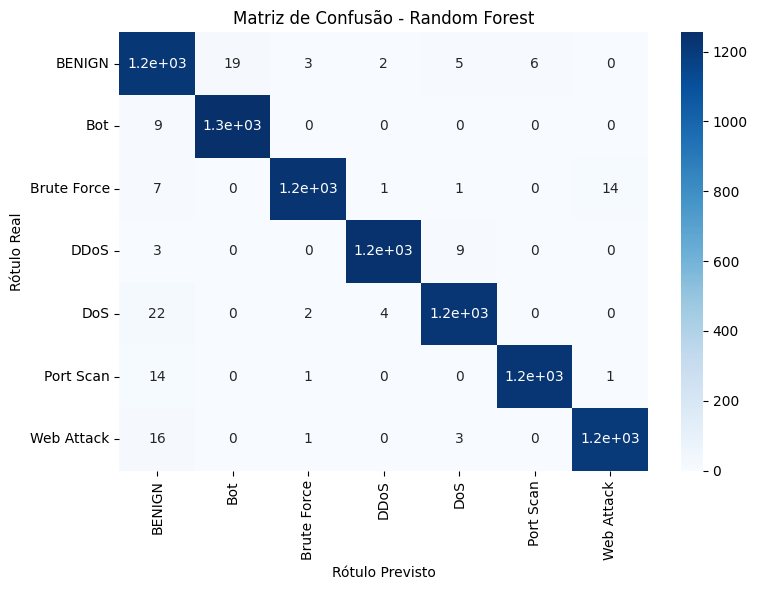

In [185]:
y_pred_rf = rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.tight_layout()
plt.show()

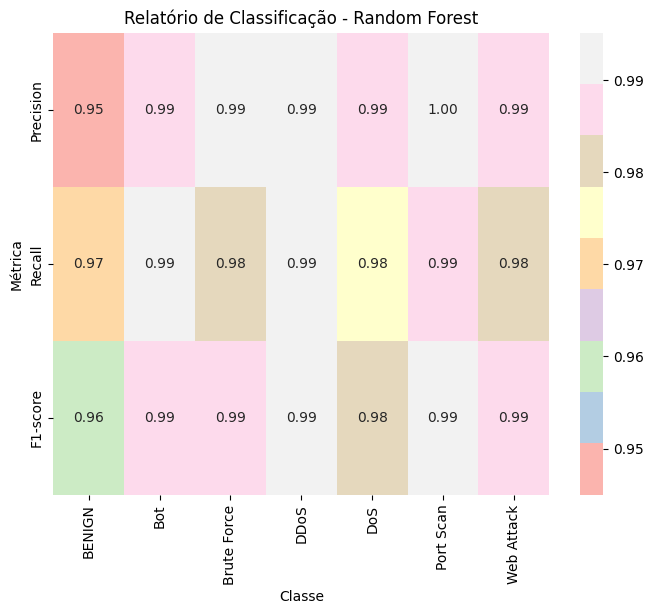

In [186]:
target_names = rf.classes_
metrics = classification_report(y_true=y_test, y_pred=y_pred_rf, target_names=target_names, output_dict=True)

precision = [metrics[target]['precision'] for target in target_names]
recall = [metrics[target]['recall'] for target in target_names]
f1 = [metrics[target]['f1-score'] for target in target_names]

data = [precision, recall, f1]
rows = ['Precision', 'Recall', 'F1-score']

plt.figure(figsize=(8, 6))
sns.heatmap(data, cmap='Pastel1', annot=True, fmt='.2f', xticklabels=target_names, yticklabels=rows)
plt.title('Relatório de Classificação - Random Forest')
plt.xlabel('Classe')
plt.ylabel('Métrica')
plt.show()